# 시계열 데이터 생성
## 일별 날씨

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

import warnings
warnings.filterwarnings('ignore')

In [2]:
dataset_filepath = os.getenv("HOME")+"/aiffel/stock_prediction/data/daily-min-temperatures.csv"

df = pd.read_csv(dataset_filepath)
print(type(df))
df.head

<class 'pandas.core.frame.DataFrame'>


<bound method NDFrame.head of             Date  Temp
0     1981-01-01  20.7
1     1981-01-02  17.9
2     1981-01-03  18.8
3     1981-01-04  14.6
4     1981-01-05  15.8
...          ...   ...
3645  1990-12-27  14.0
3646  1990-12-28  13.6
3647  1990-12-29  13.5
3648  1990-12-30  15.7
3649  1990-12-31  13.0

[3650 rows x 2 columns]>

In [3]:
# # Date컬럼을 index로하여 시계열데이터생성
# df = pd.read_csv(dataset_filepath, index_col = 'Date', parse_dates=True)
# print(type(df))
# df.head()

In [4]:
# 시계열
ts1 = df['Temp']
print(type(ts1))
ts1.head()

<class 'pandas.core.series.Series'>


0    20.7
1    17.9
2    18.8
3    14.6
4    15.8
Name: Temp, dtype: float64

# 시계열 안정성의 정성적 분석
### 시계열이 준비되었으므로 시각화를 통해서 안정성(Stationarity)여부 확인

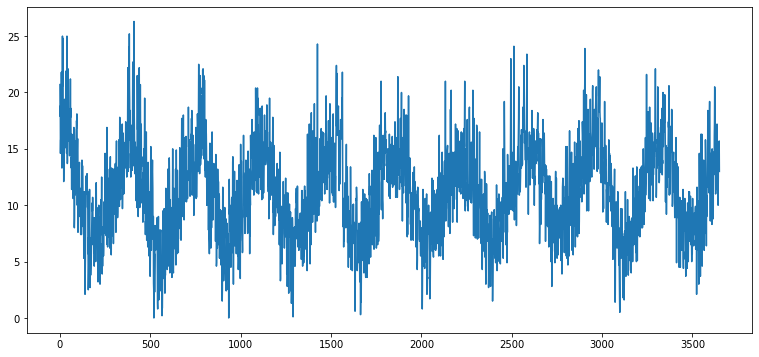

In [6]:
from matplotlib.pylab import rcParams
rcParams['figure.figsize']=13,6
plt.plot(ts1)

In [7]:
# 결측치 유무확인
ts1[ts1.isna()]

Series([], Name: Temp, dtype: float64)

### 결측치가 있다면?
1. 결측치 모두 삭제
2. 결측치 양 옆의 값들로 보간(2,4 데이터가 NAN이면 3으로 채우는 방식)

시계열 데이터에서는 보간하는 방법이 더 낫다.

Series([], Name: Temp, dtype: float64)


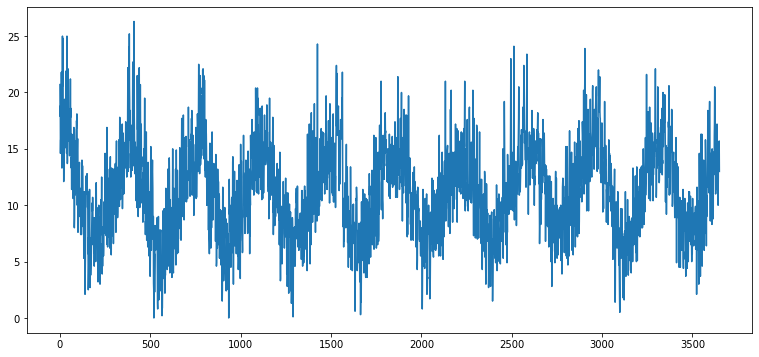

In [8]:
# 결측치 보간
ts1 = ts1.interpolate(method='time') # 보간 기준은 time
# 보간 이후 결측치 유무 확인
print(ts1[ts1.isna()])

plt.plot(ts1)

### 이동평균(MA, Moving Average)
- 수의 집합에서 특정 크기 부분 집합을 연속적으로 이동하며 산출한 평균
- 일정한 크기의 부분집합을 평균 계산에 활용하는 것이 특징
- 이 부분집합들을 이동시키며 연속적인 평균값을 산출함으로써 평균값의 흐름을 알 수 있게 된다.

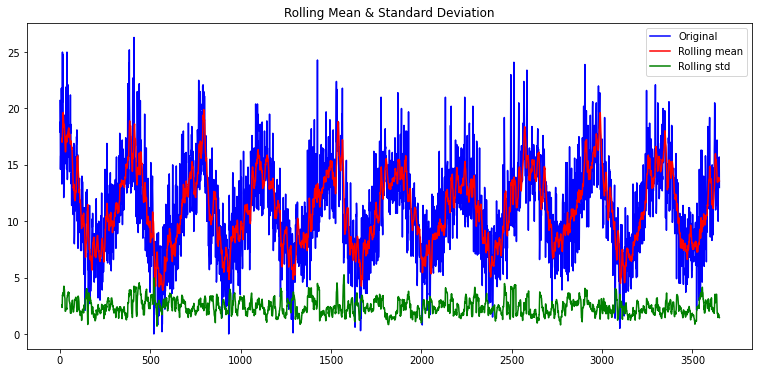

In [9]:
# 이동평균 함수
def plot_rolling_statistics(timeseries, window=12):
    rolmean = timeseries.rolling(window=window).mean() # 이동평균 시계열
    rolstd = timeseries.rolling(window=window).std() # 이동평균 표준편차
    
    # 원본 시계열, 이동평균, 이동표준편차를 plot으로 시각화
    orig = plt.plot(timeseries, color='blue', label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling mean')
    std = plt.plot(rolstd, color='green', label='Rolling std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    
plot_rolling_statistics(ts1, window=12)

# 시계열 데이터 비교
## 월별 항공 승객 수

In [10]:
dataset_filepath = os.getenv('HOME')+'/aiffel/stock_prediction/data/airline-passengers.csv'
df = pd.read_csv(dataset_filepath, index_col='Month',parse_dates=True).fillna(0)
print(type(df))
df.head()

<class 'pandas.core.frame.DataFrame'>


,Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


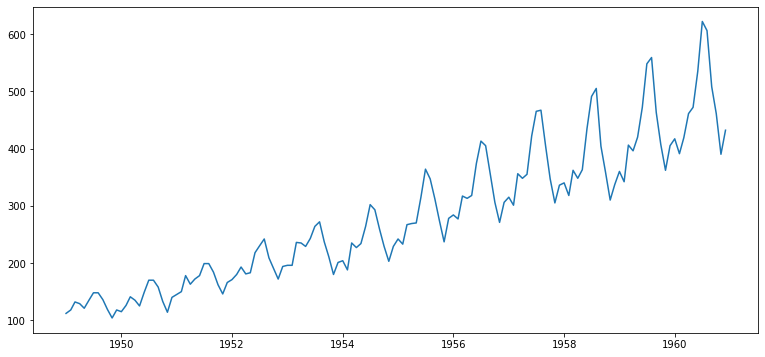

In [11]:
ts2=df['Passengers']
plt.plot(ts2)

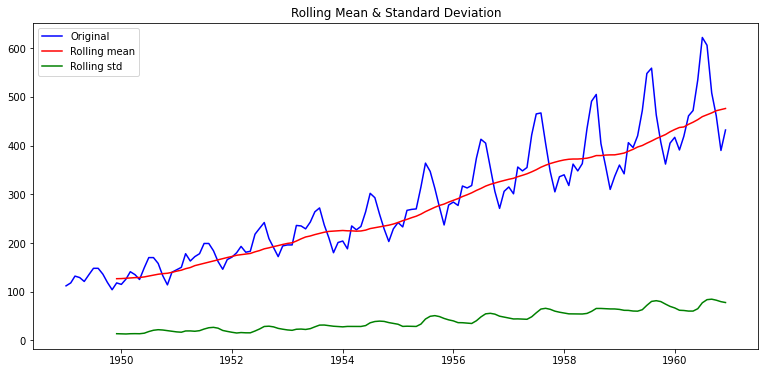

In [12]:
plot_rolling_statistics(ts2, window=12)

### statsmodels 패키지, adfuller 메소드

In [13]:
# Augmented Dickey-Fuller Test 수행하는 코드
from statsmodels.tsa.stattools import adfuller

def augmented_dickey_fuller_test(timeseries):
    dftest = adfuller(timeseries, autolag='AIC')
    # adfuller 메소드가 리턴한 결과를 정리하여 출력
    print('results of Dickey-Fuller Test:')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key]=value
    print(dfoutput)

In [14]:
augmented_dickey_fuller_test(ts1)

results of Dickey-Fuller Test:
Test Statistic                   -4.444805
p-value                           0.000247
#Lags Used                       20.000000
Number of Observations Used    3629.000000
Critical Value (1%)              -3.432153
Critical Value (5%)              -2.862337
Critical Value (10%)             -2.567194
dtype: float64


- p-value가 0에 가깝게 나타났으므로 귀무가설은 기각되고 시계열은 안정적이라는 대립가설이 채택

In [15]:
augmented_dickey_fuller_test(ts2)

results of Dickey-Fuller Test:
Test Statistic                   0.815369
p-value                          0.991880
#Lags Used                      13.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64


- p-value가 1에 가깝게 나타났는데, 옳다는 직접적증거는 아니지만 귀무가설을 기각할 수는 없으므로 안정적인 시계열이라고는 할 수 없다.

### 안정적이지 않은 시계열을 분석하려면?

- 안정적인 시계열로 바꾼다

### 크게 2가지
1. 정성적인 분석을 통해 안정적인 특성을 가지도록 기존의 시계열 데이터를 가공/변형하는 시도
2. 시계열 분해 기법을 적용

# 1. Stationary한 시계열로 가공하기

## 1.1 Log함수로 변환

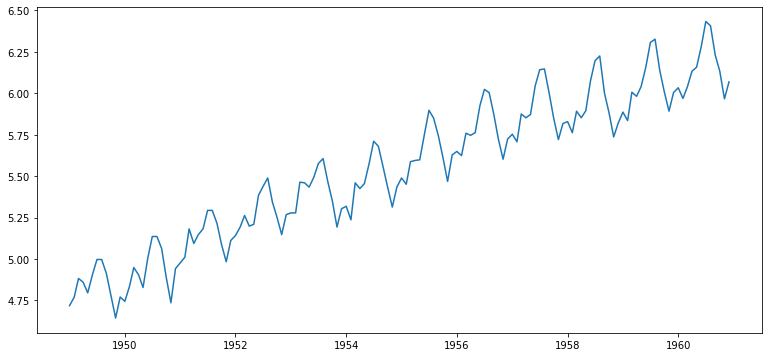

In [16]:

ts_log = np.log(ts2)
plt.plot(ts_log)

In [17]:
augmented_dickey_fuller_test(ts_log)

results of Dickey-Fuller Test:
Test Statistic                  -1.717017
p-value                          0.422367
#Lags Used                      13.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64


## 1.2 Moving Average제거

log함수에서 moving average를 빼주면 ?

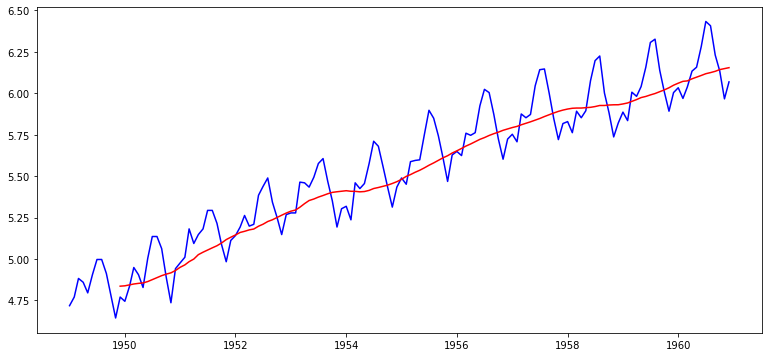

In [18]:
moving_avg = ts_log.rolling(window=12).mean() # moving average
plt.plot(ts_log, color='blue')
plt.plot(moving_avg, color='red')

In [19]:
ts_log_moving_avg = ts_log - moving_avg # trend(변화량) 제거

ts_log_moving_avg.head(15)

Month
1949-01-01         NaN
1949-02-01         NaN
1949-03-01         NaN
1949-04-01         NaN
1949-05-01         NaN
1949-06-01         NaN
1949-07-01         NaN
1949-08-01         NaN
1949-09-01         NaN
1949-10-01         NaN
1949-11-01         NaN
1949-12-01   -0.065494
1950-01-01   -0.093449
1950-02-01   -0.007566
1950-03-01    0.099416
Name: Passengers, dtype: float64

In [20]:
# 앞의 11개의 데이터는 moving Average가 계산되지 않으므로 제거
ts_log_moving_avg.dropna(inplace=True)
ts_log_moving_avg.head(15)

Month
1949-12-01   -0.065494
1950-01-01   -0.093449
1950-02-01   -0.007566
1950-03-01    0.099416
1950-04-01    0.052142
1950-05-01   -0.027529
1950-06-01    0.139881
1950-07-01    0.260184
1950-08-01    0.248635
1950-09-01    0.162937
1950-10-01   -0.018578
1950-11-01   -0.180379
1950-12-01    0.010818
1951-01-01    0.026593
1951-02-01    0.045965
Name: Passengers, dtype: float64

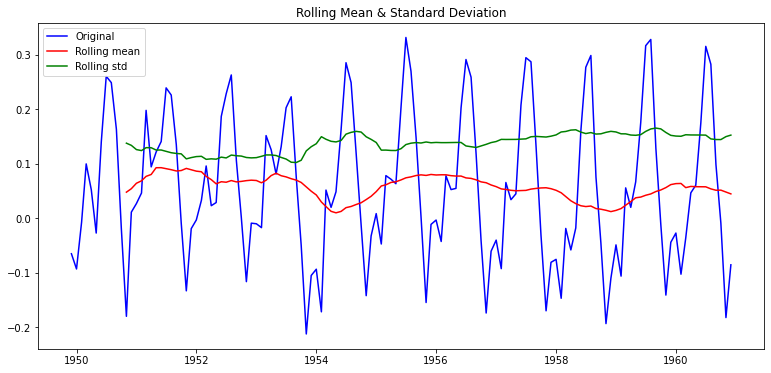

In [21]:
# 이동평균
plot_rolling_statistics(ts_log_moving_avg)

In [22]:
augmented_dickey_fuller_test(ts_log_moving_avg)

results of Dickey-Fuller Test:
Test Statistic                  -3.162908
p-value                          0.022235
#Lags Used                      13.000000
Number of Observations Used    119.000000
Critical Value (1%)             -3.486535
Critical Value (5%)             -2.886151
Critical Value (10%)            -2.579896
dtype: float64


## 1.3 차분(Differencing) - 계절성(Seasonality) 상쇄하기
- 시계열을 한 스텝 앞으로 시프트 한 시계열을 원래 시계열에서 빼주는 방법.
- 현재 스텝 값 - 직전 스텝 값 == 이번 스텝에서 발생한 변화량을 의미

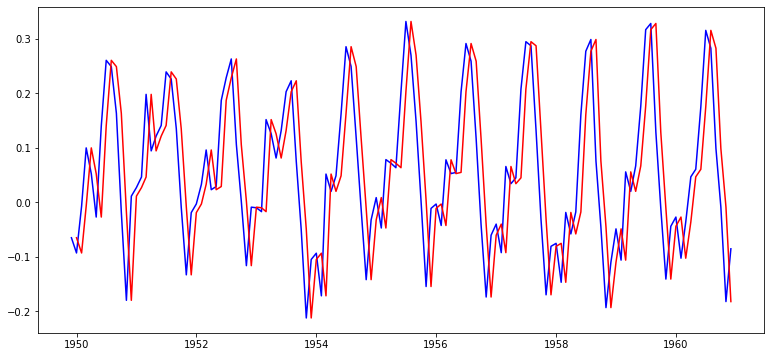

In [23]:
# 시프트 한 시계열 , 원본 시계열

ts_log_moving_avg_shift = ts_log_moving_avg.shift()
plt.plot(ts_log_moving_avg, color='blue')
plt.plot(ts_log_moving_avg_shift, color='red')

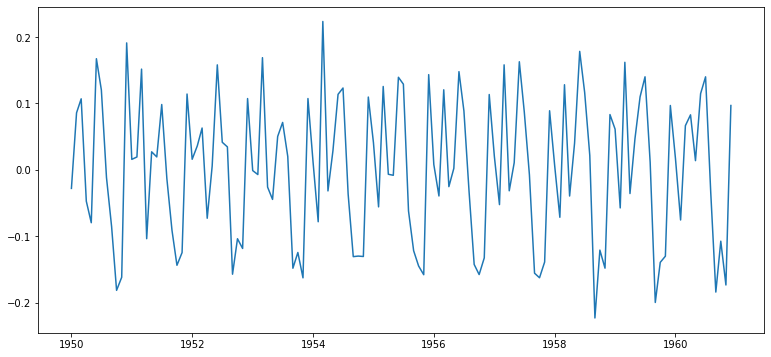

In [24]:
# 원본 시계열에서 시프트 한 시계열을 뺀 그래프
ts_log_moving_avg_diff = ts_log_moving_avg - ts_log_moving_avg_shift
ts_log_moving_avg_diff.dropna(inplace=True)

plt.plot(ts_log_moving_avg_diff)

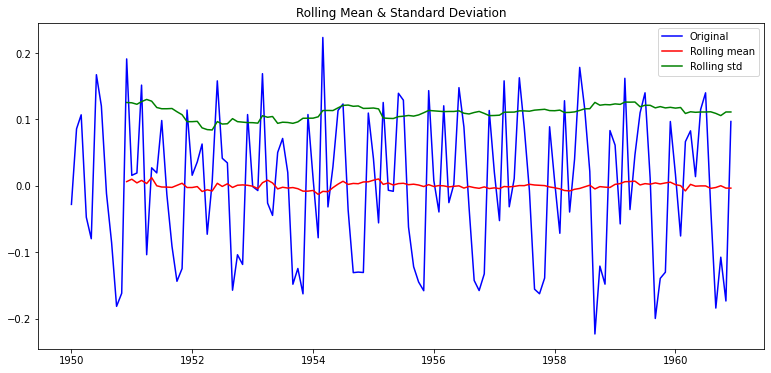

In [25]:
# 이동평균,이동표준편차 안정성 여부
plot_rolling_statistics(ts_log_moving_avg_diff)

In [26]:
# 차분의 효과
augmented_dickey_fuller_test(ts_log_moving_avg_diff)

results of Dickey-Fuller Test:
Test Statistic                  -3.912981
p-value                          0.001941
#Lags Used                      13.000000
Number of Observations Used    118.000000
Critical Value (1%)             -3.487022
Critical Value (5%)             -2.886363
Critical Value (10%)            -2.580009
dtype: float64


- 이동평균을 빼주어 Trend를 제거한 시계열에 1차 차분을 적용하여 상쇄한 결과, p-value가 1/10 정도로 줄었다.
- 데이터에 따라서 2차차분, 3차차분 등을 적용하면 p-value를 더욱 더 낮출 수 있을지도 모른다.

# 2. 시계열 분해
- statsmodels 라이브러리에는 ```seasonal_decompose``` 메소드를 통해서 trend, seasonality를 직접 분리 할 수 있는 기능이 있다.
- 이 기능을 활용하면 moving_average제거, differencing등을 하지 않고도 안정적인 시계열을 분리해 낼 수 있다.

ts_log부터 출발

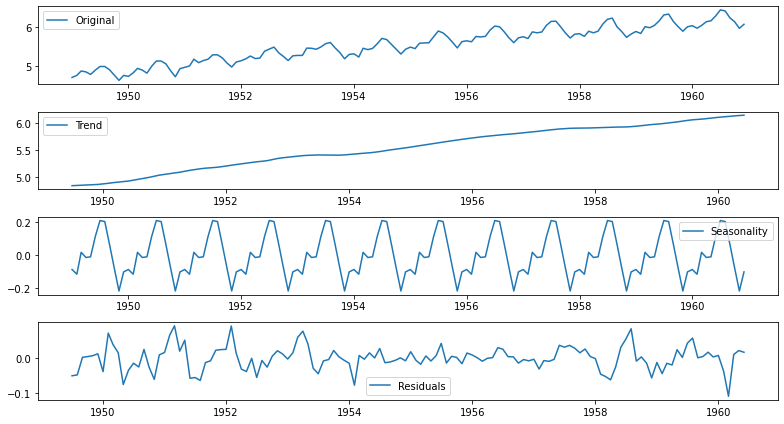

In [27]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_log)

trend = decomposition.trend # 시간 추이에 따라 나타나는 평균값 변화
seasonal = decomposition.seasonal # 계절성(패턴이 파악되지 않은 주기적 변화)
residual = decomposition.resid # 원본 - trend - seasonality, 뒤집어말하면 Original = residual + trend + seasonality

plt.rcParams['figure.figsize'] = (11,6)
plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')

plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')

plt.subplot(413)
plt.plot(seasonal, label='Seasonality')
plt.legend(loc='best')

plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')

plt.tight_layout()

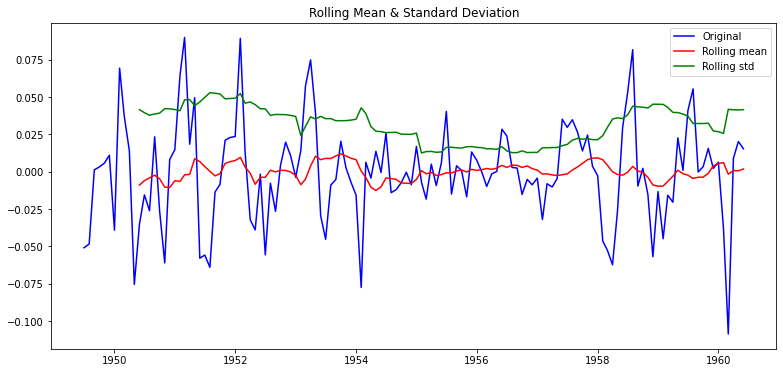

In [28]:
# Residual 안정성
plt.rcParams['figure.figsize'] = (13,6)
plot_rolling_statistics(residual)

In [29]:
residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)

results of Dickey-Fuller Test:
Test Statistic                -6.332387e+00
p-value                        2.885059e-08
#Lags Used                     9.000000e+00
Number of Observations Used    1.220000e+02
Critical Value (1%)           -3.485122e+00
Critical Value (5%)           -2.885538e+00
Critical Value (10%)          -2.579569e+00
dtype: float64


# ARIMA 모델 정의
- ``` ARIMA(AutoRegressive Integrated Moving Average)```= AR(자기회귀) + I(차분누적) + MA(이동평균)
- 주식값이 항상 일정한 균형 수준을 유지할 것이라고 예측하는 관점이 AR로 모델링하는 관점
- 주식값이 최근의 증감 패턴을 지속할 것이라고 보는 관점이 MA로 모델링하는 관점

### ARIMA 모델의 모수 p,q,d
- p : AR의 시차
- q : MA의 시차
- d : 차분누적(I)의 횟수

적절한 모수를 선택하는 방법에는 많은 것들이 있지만, 대표적으로 `ACF`, `PACF` 가 있다.

<function matplotlib.pyplot.show(close=None, block=None)>

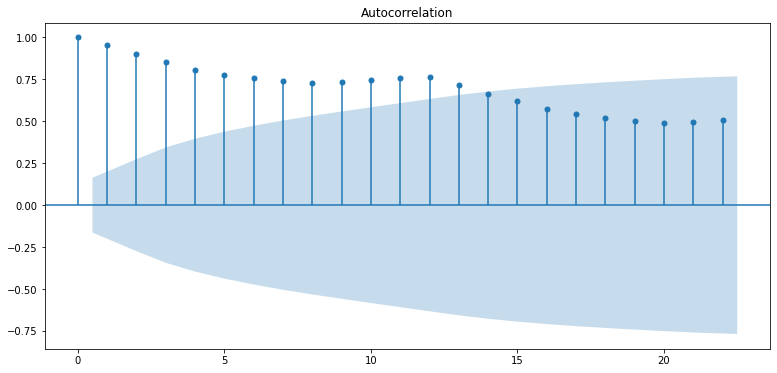

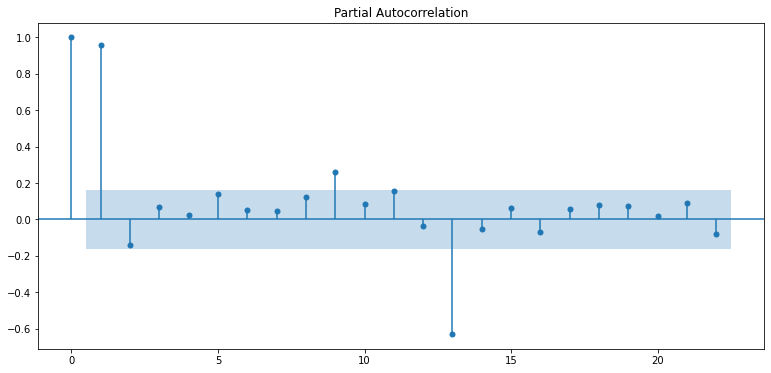

In [30]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(ts_log)
plot_pacf(ts_log)
plt.show

- PACF 그래프를 볼때 p가 2이상인 구간에서 PACF 는 거의 0에 가까워지기 때문

results of Dickey-Fuller Test:
Test Statistic                  -2.717131
p-value                          0.071121
#Lags Used                      14.000000
Number of Observations Used    128.000000
Critical Value (1%)             -3.482501
Critical Value (5%)             -2.884398
Critical Value (10%)            -2.578960
dtype: float64


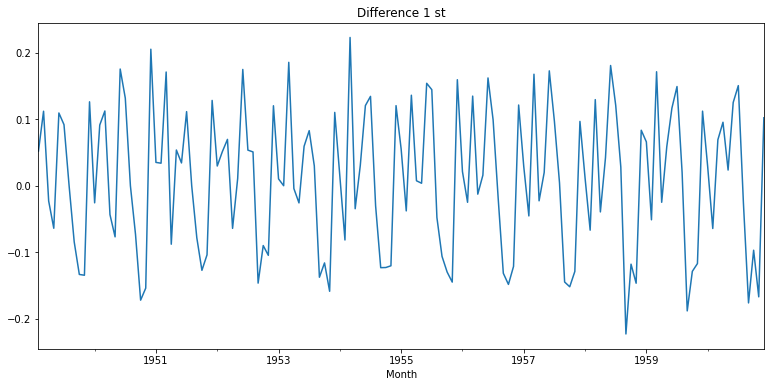

In [31]:
# 1차 차분
diff_1 = ts_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1 st')

augmented_dickey_fuller_test(diff_1)

results of Dickey-Fuller Test:
Test Statistic                -8.196629e+00
p-value                        7.419305e-13
#Lags Used                     1.300000e+01
Number of Observations Used    1.280000e+02
Critical Value (1%)           -3.482501e+00
Critical Value (5%)           -2.884398e+00
Critical Value (10%)          -2.578960e+00
dtype: float64


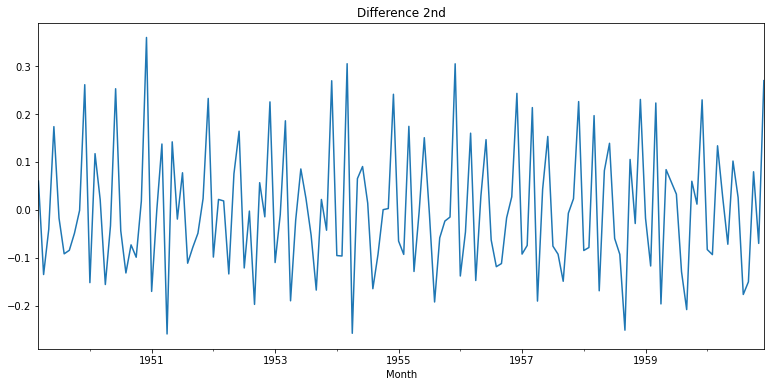

In [32]:
# 2차 차분
diff_2 = diff_1.diff(periods=1).iloc[1:]
diff_2.plot(title='Difference 2nd')
augmented_dickey_fuller_test(diff_2)

# train data 분리

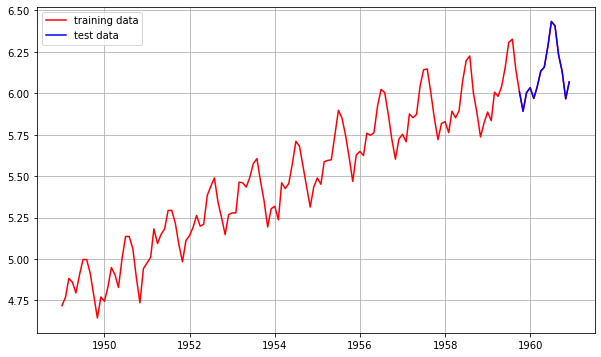

In [35]:
train_data, test_data = ts_log[:int(len(ts_log)*0.9)], ts_log[(int(len(ts_log)*0.9)):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(ts_log, c='r', label='training data')
plt.plot(test_data, c='b', label='test data')
plt.legend()

In [36]:
# 데이터셋의 형태
print(ts_log[:2])
print(train_data.shape)
print(test_data.shape)

Month
1949-01-01    4.718499
1949-02-01    4.770685
Name: Passengers, dtype: float64
(129,)
(15,)


# ARIMA 모델 훈련과 추론

- p=1, d=1, q=0을 모수로 가지는 모델을 사용

In [38]:
import warnings
warnings.filterwarnings('ignore')

from statsmodels.tsa.arima.model import ARIMA
# build model
model = ARIMA(train_data, order=(1,1,0))
fitted_m = model.fit()
print(fitted_m.summary())

                               SARIMAX Results                                
Dep. Variable:             Passengers   No. Observations:                  129
Model:                 ARIMA(1, 1, 0)   Log Likelihood                 107.558
Date:                Thu, 18 Nov 2021   AIC                           -211.117
Time:                        03:00:53   BIC                           -205.413
Sample:                    01-01-1949   HQIC                          -208.799
                         - 09-01-1959                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1853      0.100      1.852      0.064      -0.011       0.381
sigma2         0.0109      0.002      5.815      0.000       0.007       0.015
Ljung-Box (L1) (Q):                   0.07   Jarque-

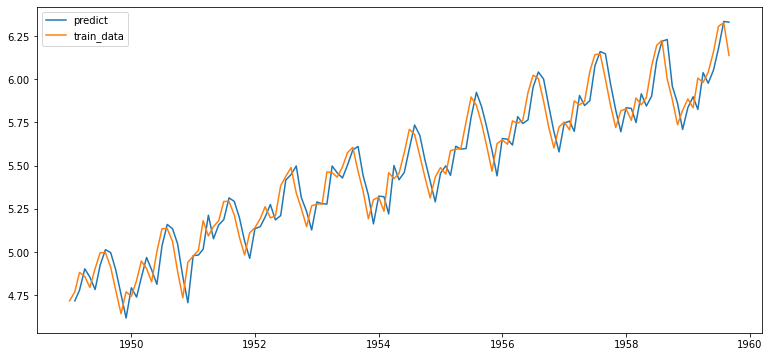

In [39]:
# ARIMA model 훈련
fitted_m = fitted_m.predict()
fitted_m = fitted_m.drop(fitted_m.index[0])
plt.plot(fitted_m, label='predict')
plt.plot(train_data, label = 'train_data')
plt.legend()

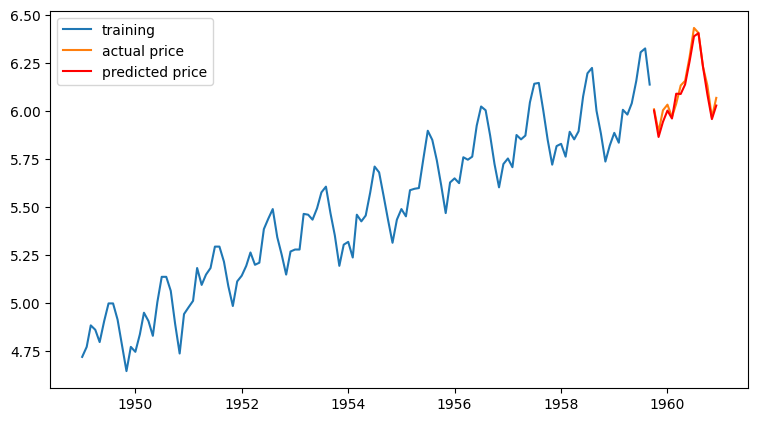

In [42]:
# forecast를 이용하여 테스트 데이터 구간의 데이터를 예측
model = ARIMA(train_data, order=(14,1,0)) # p값 10으로 테스트
fitted_m = model.fit()
fc = fitted_m.forecast(len(test_data), alpha=0.05)

fc_series = pd.Series(fc, index=test_data.index)

plt.figure(figsize=(9,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, label='actual price')
plt.plot(fc_series, c='r', label='predicted price')
plt.legend()
plt.show()

In [43]:
# 전부 원본 스케일로 돌린 후 계산
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  227.0652386843259
MAE:  12.259584199909712
RMSE:  15.068684039567819
MAPE: 2.71%
